In [1]:
import os, random, pickle
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from math import sin, cos, acos, radians
from sklearn.metrics import confusion_matrix

import tensorflow as tf
import keras
from keras import layers
from keras import regularizers

# Mount Google Drive (if needed)
from google.colab import drive
drive.mount('/content/drive')

# Paths (adjust to your Drive layout)
DATA_ROOT = '/content/drive/MyDrive/Project/DataCollection'
DATACOMBINED = f"{DATA_ROOT}/data/dataCombined"
TRAIN_PATH = f"{DATA_ROOT}/trainData.npy"
TEST_PATH = f"{DATA_ROOT}/testData.npy"
POLY_PATH = f"{DATA_ROOT}/usaPolygonGrid.pkl"


Mounted at /content/drive


# Paths

In [ ]:
# Not needed in Colab
DATA_DIR = "../DataCollection"
DATACOMBINED = os.path.join(DATA_DIR, "data/dataCombined")
POLY_PATH = os.path.join(DATA_DIR, "usaPolygonGrid.pkl")
TRAIN_PATH = os.path.join(DATA_DIR, "trainData.npy")
TEST_PATH = os.path.join(DATA_DIR, "testData.npy")

In [2]:
# Check if key files and directories exist
print("Path Verification:")
print("DATACOMBINED exists:", os.path.isdir(DATACOMBINED))
print("TRAIN_PATH exists:", os.path.isfile(TRAIN_PATH))
print("TEST_PATH exists:", os.path.isfile(TEST_PATH))
print("POLY_PATH exists:", os.path.isfile(POLY_PATH))

Path Verification:
DATACOMBINED exists: True
TRAIN_PATH exists: True
TEST_PATH exists: True
POLY_PATH exists: True


# Data Inspection



In [3]:
# Load files
trainFiles = np.load(TRAIN_PATH)
testFiles = np.load(TEST_PATH)
usaPolygonGrid = pickle.load(open(POLY_PATH, 'rb'))

In [4]:
print(f"Number of training samples: {len(trainFiles)}")
print(f"Number of test samples: {len(testFiles)}")
print("First 3 training samples:")
print(trainFiles[:3])

Number of training samples: 4420
Number of test samples: 492
First 3 training samples:
['138+48.91912085048555,-96.55263961447604'
 '49+42.90499532534337,-112.5568108457729'
 '194+37.7950246629556,-84.48408956747008']


Sample image path: /content/drive/MyDrive/Project/DataCollection/data/dataCombined/138+48.91912085048555,-96.55263961447604/0_2024-09.jpg


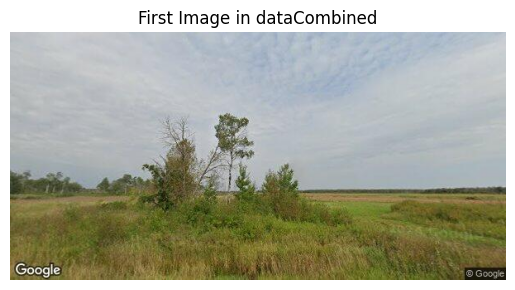

In [5]:
# Display the first image from the first triplet folder in DATACOMBINED
import PIL.Image

first_folder = os.path.join(DATACOMBINED, trainFiles[0])
first_image_path = os.path.join(first_folder, sorted(os.listdir(first_folder))[0])
print("Sample image path:", first_image_path)
img = PIL.Image.open(first_image_path)
plt.imshow(img)
plt.axis('off')
plt.title("First Image in dataCombined")
plt.show()

# Defining Model

In [6]:
def build_model(useResnet=True, inputShape=(3, 300, 600, 3), gridCount=246):
    if useResnet:
        base = keras.applications.ResNet50(include_top=True, weights='imagenet', input_shape=inputShape[1:])
        base.trainable = False
        cnn = keras.Sequential([base, layers.GlobalMaxPooling2D()])
    else:
        cnn = keras.Sequential([
            layers.Conv2D(64, (3,3), padding='same', activation='relu', input_shape=inputShape[1:]),
            layers.MaxPool2D(), layers.BatchNormalization(),
            layers.Conv2D(128, (3,3), padding='same', activation='relu'),
            layers.GlobalMaxPooling2D()
        ])
    model = keras.Sequential([
        layers.TimeDistributed(cnn, input_shape=inputShape),
        layers.LSTM(64),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(64, activation='relu'),
        layers.Dense(gridCount, activation='softmax')
    ])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001,), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    model.summary()
    return model


# Data Preparation

The numpy arrays from the previous notebook are not in the correct format for training. The following functions below will load the triplet images and prepare them for training. The triplet images are stored in folders named with a grid ID and latitude/longitude coordinates, e.g., "0+lat,lon/". Each folder contains three images.

In [7]:
# First set up validation set

from sklearn.model_selection import train_test_split

# Split 80% train, 20% validation
train_files, val_files = train_test_split(trainFiles, test_size=0.2, random_state=42)

# Check sizes
print(f"Training samples: {len(train_files)}")
print(f"Validation samples: {len(val_files)}")


Training samples: 3536
Validation samples: 884


In [8]:
def read_triplet_batch(fileNames, dataDir, gridCount):
    inputSize=(300,600)
    X, y = [], []
    for name in fileNames:
        folder = os.path.join(dataDir, name)
        imgs = [
            np.array(tf.keras.utils.load_img(os.path.join(folder, img), target_size=inputSize))
            for img in sorted(os.listdir(folder))
        ]
        X.append(imgs)
        y.append(int(name.split('+')[0]))
    X = np.array(X)
    y = keras.utils.to_categorical(y, num_classes=gridCount)
    return X, y

class TripletDataGenerator(keras.utils.Sequence):
    def __init__(self, fileNames, dataDir, gridCount, batch_size):
        self.fileNames = fileNames
        self.dataDir = dataDir
        self.gridCount = gridCount
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.fileNames) / self.batch_size))

    def __getitem__(self, idx):
        batch_files = self.fileNames[idx * self.batch_size:(idx + 1) * self.batch_size]
        return read_triplet_batch(batch_files, self.dataDir, self.gridCount)

# Training

In [ ]:
# Add this to build_model params to enable checkpoints

checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath='/content/drive/MyDrive/Project/Models/model_3_{epoch:02d}.keras',
    save_weights_only=False,
    save_freq='epoch',
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 3, 128)         │        75,904 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 246)            │        15,990 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 157,878 (616.71 KB)

 Trainable params: 157,750 (616.21 KB)

 Non-trainable params: 128 (512.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/35
111/111 ━━━━━━━━━━━━━━━━━━━━ 8690s 78s/step - categorical_accuracy: 0.0039 - loss: 5.5190 - val_categorical_accuracy: 0.0045 - val_loss: 5.5100
Epoch 2/35
111/111 ━━━━━━━━━━━━━━━━━━━━ 126s 1s/step - categorical_accuracy: 0.0049 - loss: 5.5048 - val_categorical_accuracy: 0.0023 - val_loss: 5.5124
Epoch 3/35
111/111 ━━━━━━━━━━━━━━━━━━━━ 124s 1s/step - categorical_accuracy: 0.0046 - loss: 5.5054 - val_categorical_accuracy: 0.0023 - val_loss: 5.5145
Epoch 4/35
111/111 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - categorical_accuracy: 0.0039 - loss: 5.5040 - val_categorical_accuracy: 0.0045 - val_loss: 5.5174
Epoch 5/35
111/111 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - categorical_accuracy: 0.0067 - loss: 5.5026 - val_categorical_accuracy: 0.0045 - val_loss: 5.5227
Epoch 6/35
111/111 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - categorical_accuracy: 0.0039 - loss: 5.5007 - val_categorical_accuracy: 0.0045 - val_loss: 5.5257
Epoch 7/35
111/111 ━━━━━━━━━━━━━━━━━━━━ 124s 1s/step - categorical_accuracy: 0.0

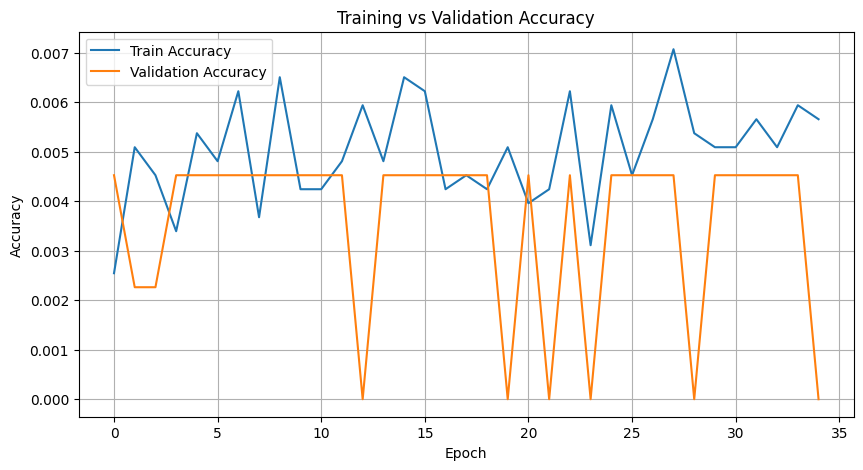

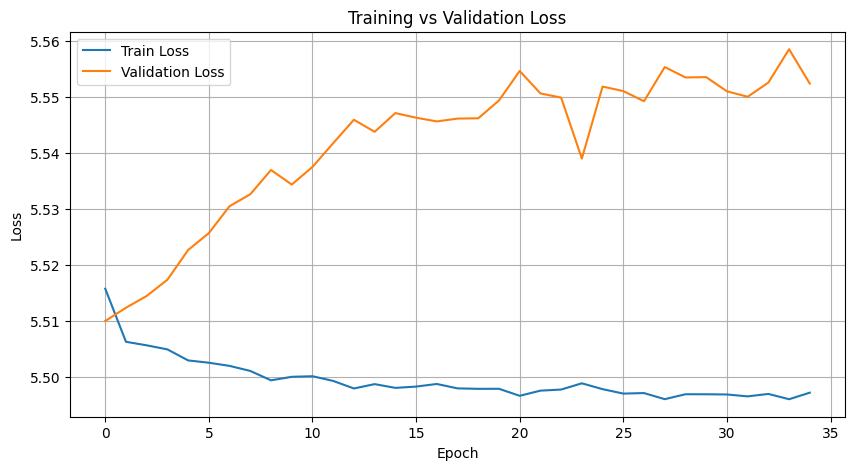

In [9]:
assets_dir = '/content/drive/MyDrive/Project/Assets'
os.makedirs(assets_dir, exist_ok=True)

batch_size = 32
epochs = 35
gridCount = 246

model_02 = build_model(inputShape=(3, 300, 600, 3), gridCount=gridCount)
train_generator = TripletDataGenerator(train_files, DATACOMBINED, gridCount, batch_size)
val_generator = TripletDataGenerator(val_files, DATACOMBINED, gridCount, batch_size)

history = model_02.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
)

# Plotting Accuracy
plt.figure(figsize=(10,5))
plt.plot(history.history['categorical_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Plotting Loss
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
loss_plot_path = os.path.join(assets_dir, 'model_02_loss_plot.png')
plt.savefig(loss_plot_path)
plt.show()

# Evaluation

In [22]:
def spherical_cosine(lat1, lon1, lat2, lon2):
    R = 3958.8  # Earth's radius in miles
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    return R * acos(sin(lat1)*sin(lat2) + cos(lat1)*cos(lat2)*cos(lon2 - lon1))

def centroid_distance(p1, p2):
    c1, c2 = Polygon(p1).centroid, Polygon(p2).centroid
    return spherical_cosine(c1.y, c1.x, c2.y, c2.x)

def evaluate_model(model, testFiles, polyGrid, dataDir):
    total = 0
    X_test, y_test = read_triplet_batch(testFiles, dataDir, gridCount=246)
    preds = model.predict(X_test)
    for i in range(len(preds)):
        true_idx = np.argmax(y_test[i])
        pred_idx = np.argmax(preds[i])
        total += centroid_distance(polyGrid[true_idx], polyGrid[pred_idx])
    return total / len(preds)

avg_dist = evaluate_model(model_02, testFiles, usaPolygonGrid, DATACOMBINED)
print(f"Average Distance Error: {avg_dist:.2f} miles")


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 209ms/step
Average Distance Error: 1113.16 miles


In [ ]:
model_02.save('/content/drive/MyDrive/Project/Models/model_02.keras')

# Confusion Matrix

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def evaluate_for_cm(model, testFiles, polyGrid, dataDir):
    total = 0
    y_true = []
    y_pred = []

    X_test, y_test = read_triplet_batch(testFiles, dataDir, gridCount=246)
    preds = model.predict(X_test)

    for i in range(len(preds)):
        true_idx = np.argmax(y_test[i])
        pred_idx = np.argmax(preds[i])
        y_true.append(true_idx)
        y_pred.append(pred_idx)

        total += centroid_distance(polyGrid[true_idx], polyGrid[pred_idx])

    avg_distance = total / len(preds)
    print(f"Average Distance Error: {avg_distance:.2f} miles")

    return avg_distance, y_true, y_pred


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 215ms/step
Average Distance Error: 1113.16 miles


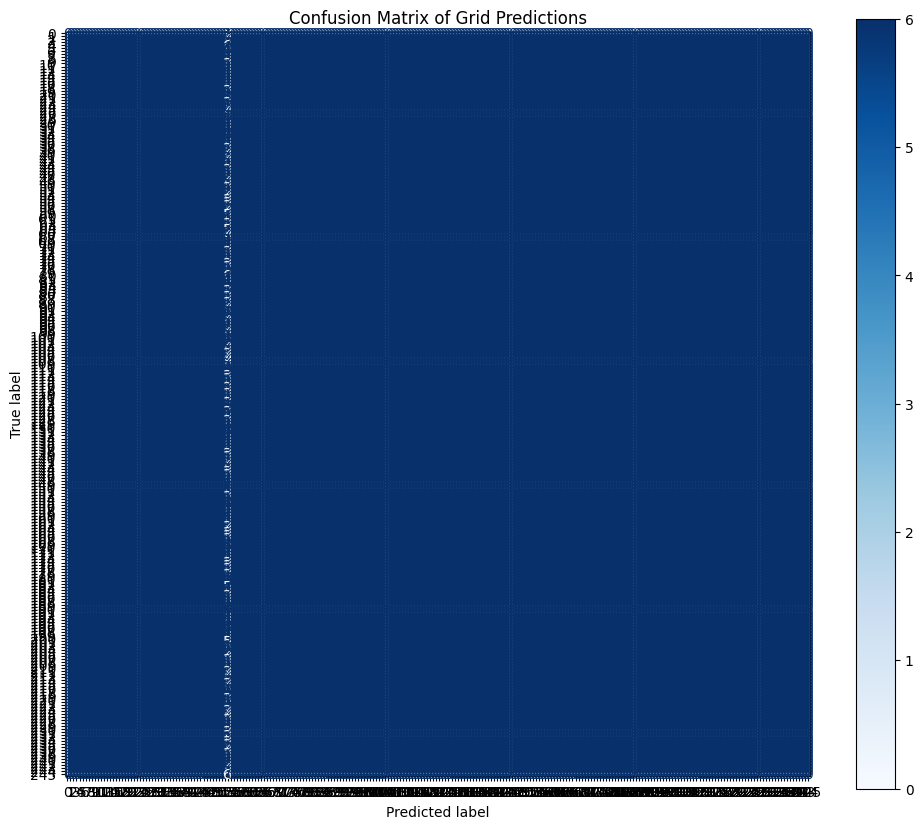

In [18]:
avg_dist, y_true, y_pred = evaluate_model(model_02, testFiles, usaPolygonGrid, DATACOMBINED)


cm = confusion_matrix(y_true, y_pred, labels=np.arange(246))

fig, ax = plt.subplots(figsize=(12, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax, cmap='Blues', values_format=".0f")
plt.title("Confusion Matrix of Grid Predictions")
conf_matrix_path = os.path.join(assets_dir, 'confusion_matrix_01.png')
plt.savefig(conf_matrix_path)
plt.show()

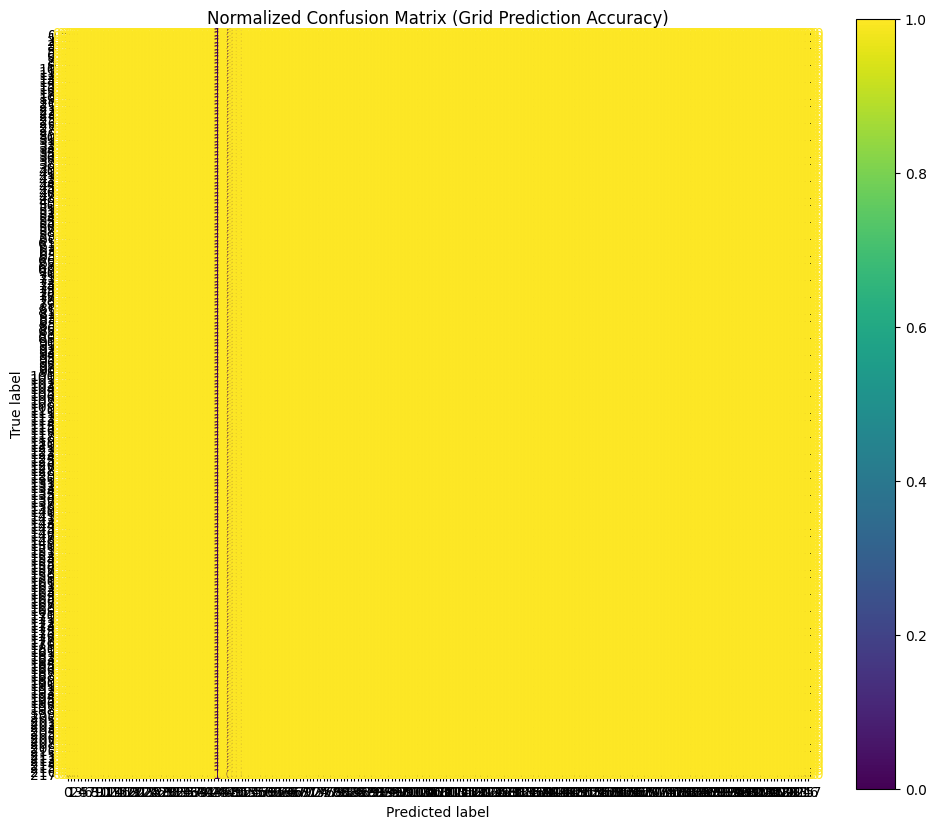

In [19]:
cm_normalized = confusion_matrix(y_true, y_pred, normalize='true')

fig, ax = plt.subplots(figsize=(12, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized)
disp.plot(ax=ax, cmap='viridis', values_format=".2f")
plt.title("Normalized Confusion Matrix (Grid Prediction Accuracy)")
plt.show()


# Training with ResNet50

Simply set the ResNet flag to True in the model definition code block before training

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_1              │ (None, 3, 128)         │        75,904 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 246)            │        15,990 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 157,878 (616.71 KB)

 Trainable params: 157,750 (616.21 KB)

 Non-trainable params: 128 (512.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/35
111/111 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/step - categorical_accuracy: 0.0031 - loss: 5.5179 - val_categorical_accuracy: 0.0011 - val_loss: 5.5092
Epoch 2/35
111/111 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - categorical_accuracy: 0.0032 - loss: 5.5044 - val_categorical_accuracy: 0.0034 - val_loss: 5.5112
Epoch 3/35
111/111 ━━━━━━━━━━━━━━━━━━━━ 126s 1s/step - categorical_accuracy: 0.0034 - loss: 5.4982 - val_categorical_accuracy: 0.0023 - val_loss: 5.5093
Epoch 4/35
111/111 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - categorical_accuracy: 0.0097 - loss: 5.4819 - val_categorical_accuracy: 0.0023 - val_loss: 5.5213
Epoch 5/35
111/111 ━━━━━━━━━━━━━━━━━━━━ 126s 1s/step - categorical_accuracy: 0.0085 - loss: 5.4246 - val_categorical_accuracy: 0.0034 - val_loss: 5.5119
Epoch 6/35
111/111 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - categorical_accuracy: 0.0092 - loss: 5.3467 - val_categorical_accuracy: 0.0034 - val_loss: 5.4037
Epoch 7/35
111/111 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - categorical_accuracy: 0.011

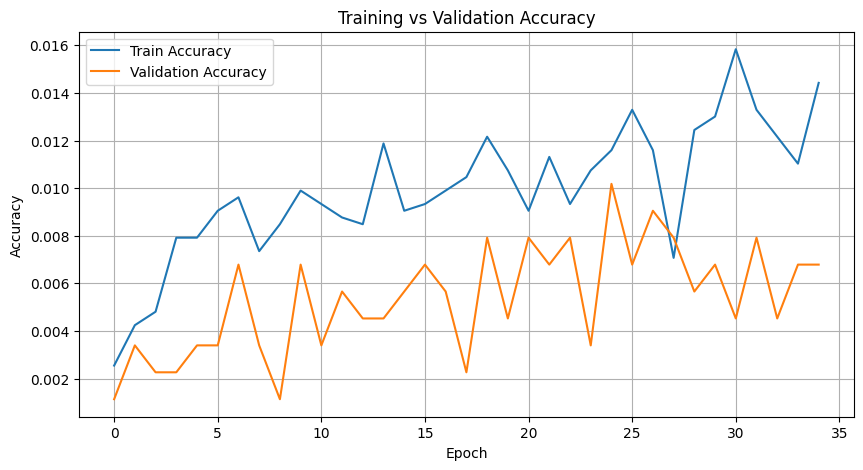

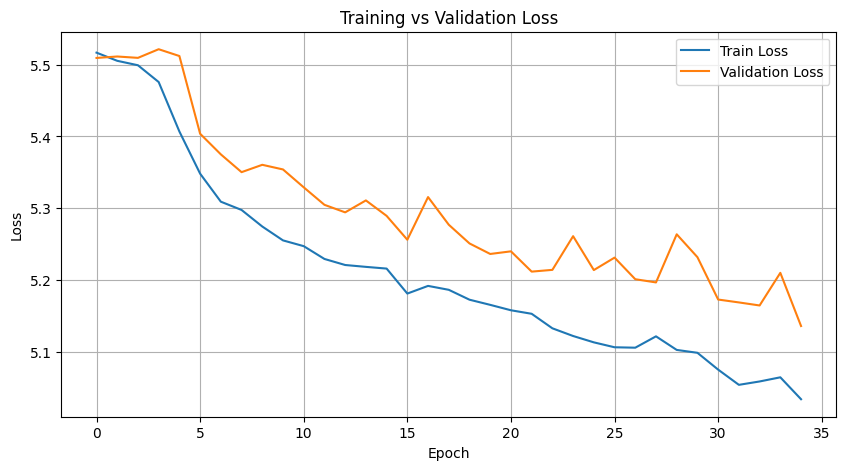

In [20]:
batch_size = 32
epochs = 35
gridCount = 246

model_03 = build_model(inputShape=(3, 300, 600, 3), gridCount=gridCount)
train_generator = TripletDataGenerator(train_files, DATACOMBINED, gridCount, batch_size)
val_generator = TripletDataGenerator(val_files, DATACOMBINED, gridCount, batch_size)

history = model_03.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
)

# Plotting Accuracy
plt.figure(figsize=(10,5))
plt.plot(history.history['categorical_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Plotting Loss
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
loss_plot_path = os.path.join(assets_dir, 'model_03_loss_plot.png')
plt.savefig(loss_plot_path)
plt.show()

# Evaluation with Pre-Trained CNN

In [23]:
def spherical_cosine(lat1, lon1, lat2, lon2):
    R = 3958.8  # Earth's radius in miles
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    # Clip the argument to the acos function to the range [-1, 1]
    arg = np.clip(sin(lat1)*sin(lat2) + cos(lat1)*cos(lat2)*cos(lon2 - lon1), -1.0, 1.0)
    return R * acos(arg)

avg_dist = evaluate_model(model_03, testFiles, usaPolygonGrid, DATACOMBINED)
print(f"Average Distance Error: {avg_dist:.2f} miles")

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 210ms/step
Average Distance Error: 857.60 miles


In [24]:
model_03.save('/content/drive/MyDrive/Project/Models/model_03.keras')
